## Texas Instruments FixedPoint IIR32 Coefficient Calculator
C2000Ware is a cohesive set of software and documentation created to minimize development time. It includes device-specific drivers, libraries, and peripheral examples. 

Part of this set of libraries is the DSP library which contains Signal processing (complex and real FFT; FIR and IIR filters) and complex math functions for fixed- and floating-point devices. A part of the singal processing library is the II32 filter, which is a set of cascaded IIR32 BiQuad filters implemented using fast fixed point (IQ) math.

The library comes with a Matlab coefficient generator called 'eziir32.m'. This is a (mostly) direct Matlab -> Python translation of the 'eziir32.m' script, used to calculate IIR32 BiQuad coefficients for use with TI's libraries. 

In [1]:
import sys
sys.path.insert(0, '../data')
%matplotlib inline

import numpy as np
from scipy.signal import lfilter, iirfilter, buttord, butter, cheb1ord, cheby1, cheb2ord, cheby2, ellipord, ellip, zpk2sos, sos2tf, dimpulse, convolve, freqz

import matplotlib.pyplot as plt

## Filter Setup

In [2]:
## Pick Filter Type
filter_type = ['Butterworth', 'Chebyshev 1', 'Chebyshev 2', 'Elliptical'][3]

## Select Filter Response
# f_res = 'lowpass'
# f_res = 'highpass'
f_res = 'bandpass'
# f_res = 'bandstop'

## Define the number of bits used to represent the filter
FMAT = 32  # (16 or 32)

## Define the Sampling Frequency
Fs = 106.667

## Pass-band Ripple in dB
Rp = 2

## Stop-band Ripple in dB
Rs = 20

## Pass-band Corner Frequency Hz
# Wp = 2
Wp = np.array([1, 2])  # array of low and high for band-pass/stop e.g. [5, 10]

## Stop-band Corner Frequency Hz
# Ws = 0.1
Ws = np.array([0.1, 4])  # array of low and high for band-pass/stop e.g. [2, 13]

In [3]:
# The Nyquist rate of the signal
nyq_rate = Fs / 2

# Normalize the frequency values
Wp = Wp / nyq_rate
Ws = Ws / nyq_rate

if filter_type == 'Butterworth':
    N, Wn = buttord(Wp, Ws, Rp, Rs)
    z, p, k = butter(N, Wn, btype=f_res, analog=False, output='zpk')
elif filter_type == 'Chebyshev 1':
    N, Wn = cheb1ord(Wp, Ws, Rp, Rs)
    z, p, k = cheby1(N, Rp, Wn, btype=f_res, analog=False, output='zpk')
elif filter_type == 'Chebyshev 2':
    N, Wn = cheb2ord(Wp, Ws, Rp, Rs)
    z, p, k = cheby2(N, Rp, Wn, btype=f_res, analog=False, output='zpk')
elif filter_type == 'Elliptical':
    N, Wn = ellipord(Wp, Ws, Rp, Rs)
    z, p, k = ellip(N, Rp, Rs, Wn, btype=f_res, analog=False, output='zpk')

In [4]:
sos = zpk2sos(z, p, k, pairing='nearest')  # convert ZP to SOS
# NOTE: take a look at Matlab command 'zp2sos', https://www.mathworks.com/help/signal/ref/zp2sos.html
# and the SciPy command 'zpk2sos', https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.zpk2sos.html
# By default Matlab orders the sections so the first row of 'sos' contains the poles farthest from the unit circle (default)
# By default SciPy orders the sections so the first row of 'sos' contains poles closest to the unit circle (default)
# The filter realizations may be different, but they should have the same response

isos = sos.copy()
N_biq = len(sos)

b = np.zeros(N_biq * 3)
a = np.zeros(N_biq * 3)

In [5]:
# The IIR32 filter implementation uses Q31 values, this uses 31 bits for the decimal and 1 bit for sign. This presents
# a problem in that we could potentially saturate the filter delay line. To keep this from happening, it's possible
# to re-scale the 'B' coefficients of each stage of the filter so that it doesn't happen. This section of code handles that.
Ni = 500

dmag = np.zeros(N_biq)
ymag = np.zeros(N_biq)
sf = np.zeros(N_biq)
for ii in range(N_biq):
    if ii == 0:
        num = np.array([1, 0, 0])
        den = sos[0, 3:6]
        t0, h0 = dimpulse((num, den, 1), n=Ni)
        dmag[ii] = np.sum(np.abs(h0[0].ravel()))
    else:
        num, den = sos2tf(sos[0:ii,:])
        den = convolve(den, sos[ii, 3:6])
        t, h = dimpulse((num, den, 1), n=Ni)
        dmag[ii] = np.sum(np.abs(h[0].ravel()))
    
    num, den = sos2tf(sos[0:ii+1, :])
    t, h = dimpulse((num, den, 1), n=Ni)
    ymag[ii] = np.sum(np.abs(h[0].ravel()))
    sf[ii] = np.max([ymag[ii], dmag[ii]])

In [6]:
# Scale the B coeff of the biquad to avoid overflow in the node
ssos = sos.copy()
for ii in range(1, N_biq):
    scale = sf[ii] / sf[ii-1]
    ssos[ii-1, 0:3] = ssos[ii-1, 0:3] / scale
    
# Scale the B coeffof the last BiQuad
ssos[N_biq-1, 0:3] = ssos[N_biq-1, 0:3] * sf[N_biq-1]

In [7]:
# Determine the Q format for representing the coefficients and inputscale factor
maxcoeff = np.max(np.max(np.abs(ssos)))
maxval = np.max([maxcoeff, 1/sf[0]])
qformat = FMAT-1
qscale = 2**qformat

if maxval > 1:
    qformat = (FMAT - 1) - np.ceil(np.log2(maxval))
    qscale = 2**qformat

In [8]:
# Represent the scaled second order setion and ISF in appropriate number format
isos = ssos*qscale
isos = np.round(isos)

isf = (1/sf[0]) * qscale  # represent the input scale factor in fixed point format
isf = np.round(isf)

# Saturate the coefficient to maximum positive value 
for ii in range(N_biq):
    for jj in range(6):
        if int(isos[ii, jj]) == int(2**(FMAT-1)):
            isos[ii, jj] = (2**(FMAT-1)) - 1

if isf == 2**(FMAT-1):
    isf = (2**(FMAT-1)) - 1

## Filter Definition (copy and paste into C source code)

In [9]:
print('/*')
print(' * Filter Response: {}'.format(f_res))
print(' * Filter Type: {}'.format(filter_type))
print(' * Sampling Frequency: {} Hz'.format(Fs))
print(' * Pass-band ripple (rp): {} dB'.format(Rp))
print(' * Stop-band ripple (rs): {} dB'.format(Rs))
print(' * Pass-band corner frequency (wp): {} Hz'.format(Wp * nyq_rate))
print(' * Stop-band corner frequency (rs): {} Hz'.format(Ws * nyq_rate))
print(' */')
print('#define IIR32_COEFF {\\')
for ii in range(N_biq):
    bis = isos[ii, 0:3][::-1]
    ais = -isos[ii, 4:6][::-1]
    line = ''.join([str(int(x)) + ', ' for x in ais]) + ''.join([str(int(x)) + ', ' for x in bis])
    if ii < (N_biq-1):
        line += '\\'
    else:
        line = line[0:-2] + '}'
    print('\t\t\t{}'.format(line))
print('\n#define IIR32_ISF\t{}'.format(int(isf)))
print('#define IIR32_NBIQ\t{}'.format(int(N_biq)))
print('#define IIR32_QFMAT\t{}'.format(int(qformat)))

/*
 * Filter Response: bandpass
 * Filter Type: Elliptical
 * Sampling Frequency: 106.667 Hz
 * Pass-band ripple (rp): 2 dB
 * Stop-band ripple (rs): 20 dB
 * Pass-band corner frequency (wp): [1. 2.] Hz
 * Stop-band corner frequency (rs): [0.1 4. ] Hz
 */
#define IIR32_COEFF {\
			-2038381, 4109283, 174358, -342324, 174358, \
			-2064805, 4154072, 1006221149, -2011129208, 1006221149}

#define IIR32_ISF	5171
#define IIR32_NBIQ	2
#define IIR32_QFMAT	21


In [10]:
print('Q format of the IIR filter coefficients: {}'.format(int(qformat)))
print('Input Scaling value: {}'.format(1/sf[0]))
print('Number of Biquads: {}'.format(int(N_biq)))

Q format of the IIR filter coefficients: 21
Input Scaling value: 0.0024659335066634434
Number of Biquads: 2


## Filter Response

In [11]:
b, a = sos2tf(sos)
w, h = freqz(b, a, worN=4096)  # w is in units of rad/sample, multiply by (Fs / 2*pi) to scale to Hz

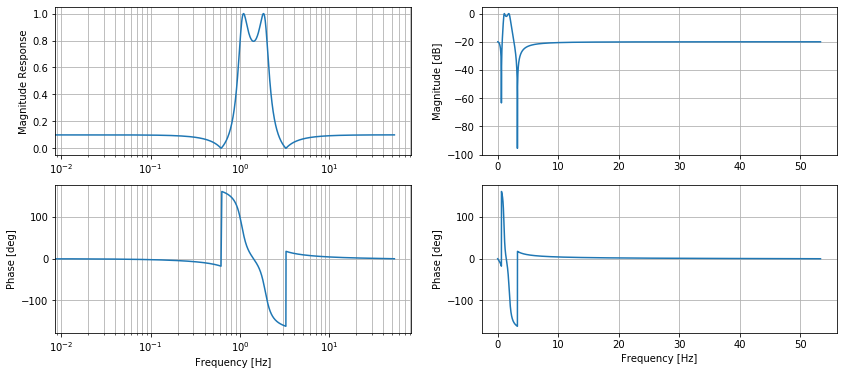

In [12]:
f = plt.figure(figsize=(14, 6))
ax1 = f.add_subplot(2, 2, 1)
ax1.plot(w*(Fs/(2*np.pi)), np.abs(h), linestyle='-', label='raw')
ax1.set_ylabel('Magnitude Response')
ax1.grid(which='both', axis='both')
ax1.set_xscale('log')
ax3 = f.add_subplot(2, 2, 3)
ax3.plot(w*(Fs/(2*np.pi)), np.unwrap(np.angle(h))*(180/np.pi))
ax3.set_ylabel('Phase [deg]')
ax3.set_xlabel('Frequency [Hz]')
ax3.grid(which='both', axis='both')
ax3.set_xscale('log')

ax2 = f.add_subplot(2, 2, 2)
ax2.plot(w*(Fs/(2*np.pi)), 20 * np.log10(np.abs(h)), linestyle='-', label='raw')
ax2.set_ylabel('Magnitude [dB]')
ax2.grid(which='both', axis='both')
ax4 = f.add_subplot(2, 2, 4)
ax4.plot(w*(Fs/(2*np.pi)), np.unwrap(np.angle(h))*(180/np.pi))
ax4.set_ylabel('Phase [deg]')
ax4.set_xlabel('Frequency [Hz]')
ax4.grid(which='both', axis='both')

## Time Domain Simulation
The test signal applied to the filter is defined below, you can change it to anything you like.

In [13]:
sig_len_s = 2
F1 = 2  # Simulated signal frequency 1 [Hz]
F2 = 20  # Simulated signal frequency 2 [Hz]

tt = np.arange(0, sig_len_s * Fs) * (1/Fs)
yy = np.sin(2*np.pi*F1*tt) + np.sin(2*np.pi*F2*tt)

x_Q31 = (2**31)*(yy/2)

filter_out_Q31 = lfilter(b, a, x_Q31)

In [14]:
x_no_scale_biq_fixed = np.zeros(len(x_Q31))
delay = np.zeros((N_biq, 3))
taps = 3
for kk in range(len(x_Q31)):
    accum = np.floor(x_Q31[kk]*(isf/2**32))
    for jj in range(N_biq):
        b_temp = isos[jj, 0:3]
        a_temp = isos[jj, 3:6]
        
        for ii in range(1, taps):
            accum = accum - np.ceil((a_temp[ii] * delay[jj, ii]) / 2**32)
        
        delay[jj, 0] = np.floor(accum*(2**(32-qformat)))
        
        accuml = 0
        for ii in range(0, taps):
            accuml = accuml + np.floor((b_temp[ii] * delay[jj, ii]) / 2**32)
        
        for ii in list(range(0, taps-2+1))[::-1]:
            delay[jj, ii+1] = delay[jj, ii]
            
        accum = np.floor(accuml)
    
    x_no_scale_biq_fixed[kk] = (accuml)*(2**(32-qformat))  # direct I from high order implementation output

Text(0.5, 0, 'Time [s]')

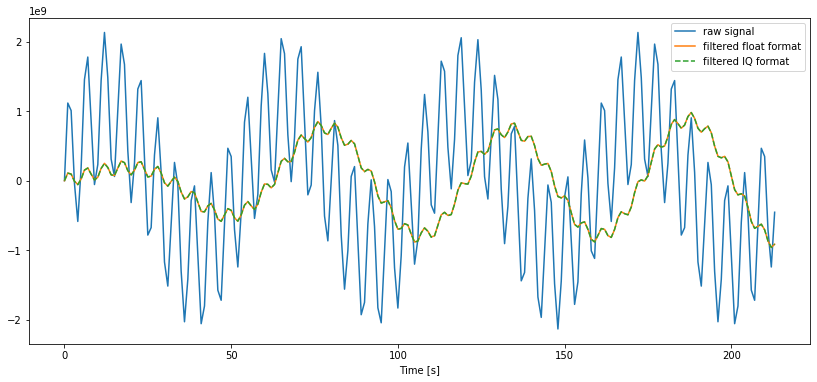

In [15]:
f = plt.figure(figsize=(14, 6))
ax1 = f.add_subplot(1, 1, 1)
ax1.plot(x_Q31, label='raw signal')
ax1.plot(filter_out_Q31, label='filtered float format')
ax1.plot(x_no_scale_biq_fixed, linestyle='--', label='filtered IQ format')
ax1.legend()
ax1.set_xlabel('Time [s]')

In [16]:
print('b = [{}'.format( (''.join(['{:.9e}, '.format(xx) for xx in b])))[:-2] + ']' )
print('a = [{}'.format( (''.join(['{:.9e}, '.format(xx) for xx in a])))[:-2] + ']' )

b = [9.836866504e-02, -3.897402489e-01, 5.827478734e-01, -3.897402489e-01, 9.836866504e-02]
a = [1.000000000e+00, -3.940274897e+00, 5.837879072e+00, -3.854540911e+00, 9.569837940e-01]
